## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Ольховик Павел Игоревич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(2 балл)**

## Срок выполнения задания:
Софт дедлайн - 8 октября 23:59  
Хард дедлайн - 15 октября 23:59


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [69]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [70]:
images_train, labels_train = next(iter(train_loader))

In [71]:
from pathlib import Path

# Предполагается, что YT_PREFIX и output[0].path определены ранее в коде
output_path = "ytTable:/" + str(Path("//home/hc/predict/desc/snb/dyn_interests/v1/clickstream_tier1_daily/") / '2025-09-01')
output_path

'ytTable:/\\\\home\\hc\\predict\\desc\\snb\\dyn_interests\\v1\\clickstream_tier1_daily\\2025-09-01'

In [72]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

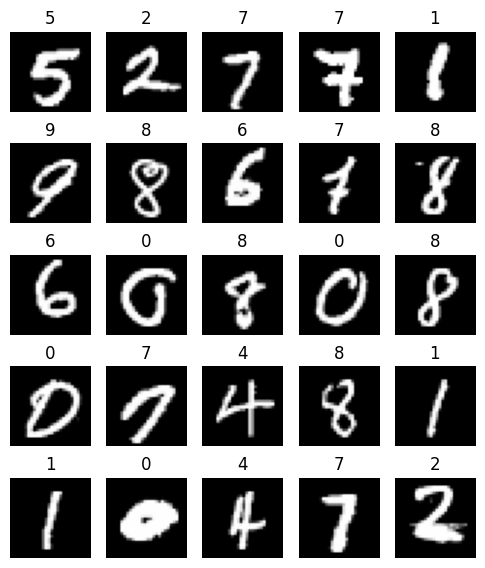

In [73]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [93]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [94]:
layer_1 = nn.Linear(28 * 28, 500)
layer_2 = nn.Linear(500, 10)


layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2 / 500)
init_layer(layer_2, 0, 2 / 10)

network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.991400420665741
forward 0.06569115072488785
backward 0.021081849932670593
backward 0.03766428306698799


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

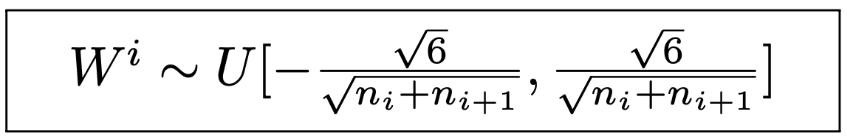

In [95]:
def init_layer(layer, input_dim, output_dim):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    border = np.sqrt(6/(input_dim + output_dim))
    weight.uniform_(- border, border)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [96]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, input_dim=28*28, output_dim=500)
init_layer(layer_2, input_dim= 500,output_dim= 10)

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.991400420665741
forward 0.6486778855323792
backward 0.021081849932670593
backward 0.011429479345679283


Разница стандартных отклонений входных и градиентов значительно уменьшилась, что означает Xavier даёт значительно большую стабильность и предотвращает взрывы градиентов.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

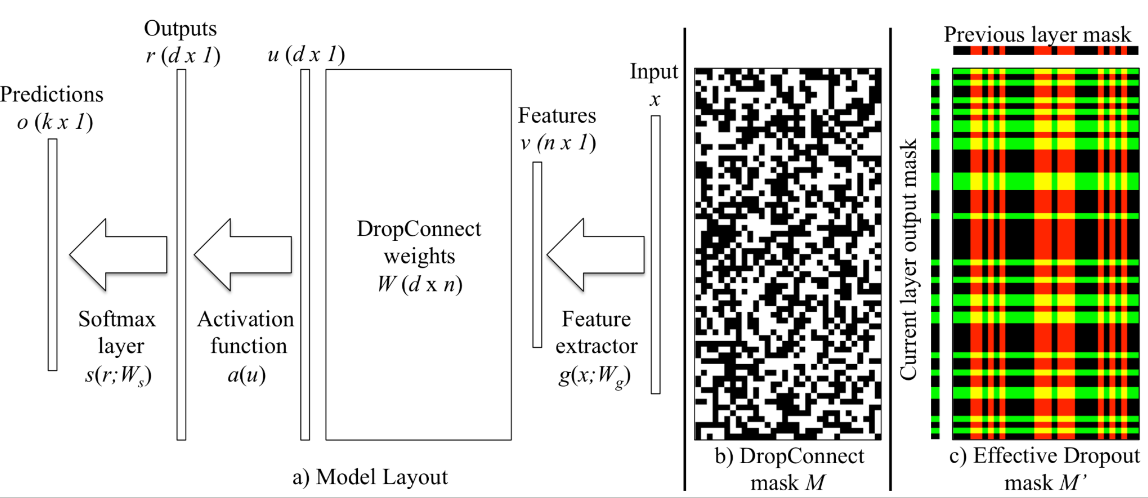

In [ ]:
# Поменял семинарский вариант чтобы убрать случайность при предсказании, праивёл к версии из документации торча
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
            return x * mask / (1-self.p)
        else:
            return x


class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p)
        else:
            mask = torch.ones_like(self.linear.weight) * (1 - self.p)
        
        mask = mask.type(torch.FloatTensor).data
        mask.requires_grad = False
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [48]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

Обучим получившуюся сеть:

In [108]:
def train(network, optimizer, loss_fn):
    train_losses = []
    test_losses = []
    for epoch in range(10):
        network.train()
        train_epoch_loss = []
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            train_epoch_loss.append(loss.item())
            # if batch_idx % 100 == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(X), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(sum(train_epoch_loss)/len(train_epoch_loss))
        network.eval()
        test_epoch_loss = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)

            test_epoch_loss.append(loss.item())
        test_losses.append(sum(test_epoch_loss)/len(test_epoch_loss))
        print(f'Epoch {epoch}: Train {train_losses[-1]:.4f}, Test {test_losses[-1]:.4f}')
    return train_losses, test_losses



#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [62]:
layersDO = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

network1 = TestNetwork(nn.Sequential(*layersDO))
optimizer1 = torch.optim.Adam(network1.parameters(), lr=0.001)
loss_fn1 = torch.nn.NLLLoss()

In [63]:
trainDO, testDO = train(network1, optimizer1, loss_fn1)

Epoch 0: Train 0.6701, Test 0.2172
Epoch 1: Train 0.3187, Test 0.1560
Epoch 2: Train 0.2457, Test 0.1220
Epoch 3: Train 0.2035, Test 0.0942
Epoch 4: Train 0.1789, Test 0.0821
Epoch 5: Train 0.1579, Test 0.0732
Epoch 6: Train 0.1456, Test 0.0715
Epoch 7: Train 0.1351, Test 0.0653
Epoch 8: Train 0.1252, Test 0.0629
Epoch 9: Train 0.1190, Test 0.0623


In [64]:
layersDC = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.ReLU(),
    DropConnect(128, 10)
]

network2 = TestNetwork(nn.Sequential(*layersDC))
optimizer2 = torch.optim.Adam(network2.parameters(), lr=0.001)
loss_fn2 = torch.nn.NLLLoss()

In [65]:
trainDC, testDC = train(network2, optimizer2, loss_fn2)

Epoch 0: Train 1.1953, Test 0.4809
Epoch 1: Train 0.5442, Test 0.2712
Epoch 2: Train 0.3752, Test 0.1894
Epoch 3: Train 0.3001, Test 0.1553
Epoch 4: Train 0.2524, Test 0.1374
Epoch 5: Train 0.2197, Test 0.1167
Epoch 6: Train 0.1989, Test 0.1031
Epoch 7: Train 0.1844, Test 0.1021
Epoch 8: Train 0.1713, Test 0.0864
Epoch 9: Train 0.1611, Test 0.0850


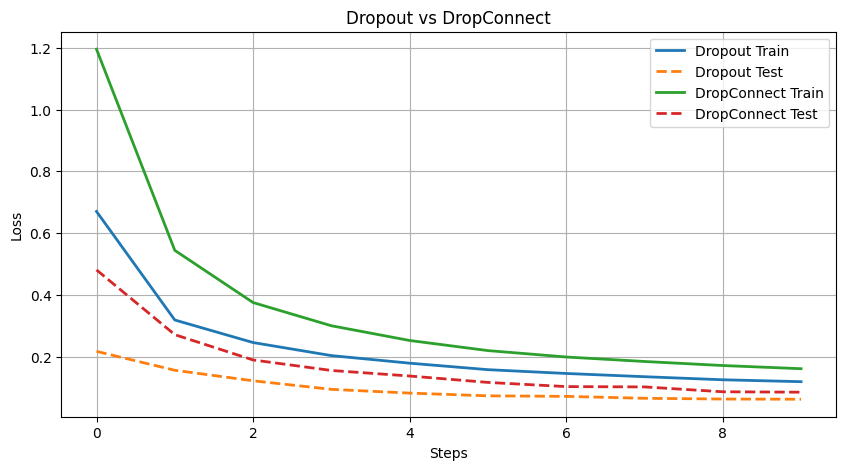

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(trainDO, label='Dropout Train', linestyle='-', linewidth=2)
plt.plot(testDO, label='Dropout Test', linestyle='--', linewidth=2)
plt.plot(trainDC, label='DropConnect Train', linestyle='-', linewidth=2)
plt.plot(testDC, label='DropConnect Test', linestyle='--', linewidth=2)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Dropout vs DropConnect')
plt.legend()
plt.grid(True)
plt.show()

DropOut сошёлся незначительно быстрее и показал лучший результат, в обуих случаях нет переобучения 

### Часть 3: Layer Normalization

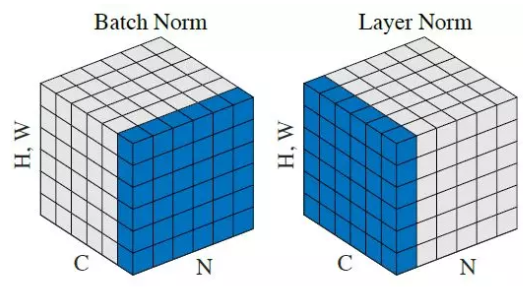

#### 3.1 Реализуйте Layer Normalization **(2 балл)**

In [113]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x, eps= 1e-6):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True, unbiased=False)
        output = (x - mean) / (std + eps)
        return output

#### Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [109]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network3 = TestNetwork(nn.Sequential(*layers))
optimizer3 = torch.optim.Adam(network3.parameters(), lr=0.001)
loss_fn3 = torch.nn.NLLLoss()

In [110]:
trainB, testB = train(network3, optimizer3, loss_fn3)

Epoch 0: Train 0.5704, Test 0.2496
Epoch 1: Train 0.2052, Test 0.1537
Epoch 2: Train 0.1464, Test 0.1186
Epoch 3: Train 0.1220, Test 0.1067
Epoch 4: Train 0.1034, Test 0.0998
Epoch 5: Train 0.0908, Test 0.0981
Epoch 6: Train 0.0824, Test 0.0782
Epoch 7: Train 0.0701, Test 0.0829
Epoch 8: Train 0.0662, Test 0.0737
Epoch 9: Train 0.0589, Test 0.0723


In [115]:
layersLN = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 10)
]

network4 = TestNetwork(nn.Sequential(*layersLN))
optimizer4 = torch.optim.Adam(network4.parameters(), lr=0.001)
loss_fn4 = torch.nn.NLLLoss()

In [116]:
trainLN, testLN = train(network4, optimizer4, loss_fn4)

Epoch 0: Train 0.2415, Test 0.1024
Epoch 1: Train 0.0903, Test 0.0697
Epoch 2: Train 0.0684, Test 0.0681
Epoch 3: Train 0.0547, Test 0.0639
Epoch 4: Train 0.0457, Test 0.0676
Epoch 5: Train 0.0406, Test 0.0594
Epoch 6: Train 0.0336, Test 0.0583
Epoch 7: Train 0.0301, Test 0.0617
Epoch 8: Train 0.0257, Test 0.0588
Epoch 9: Train 0.0234, Test 0.0564


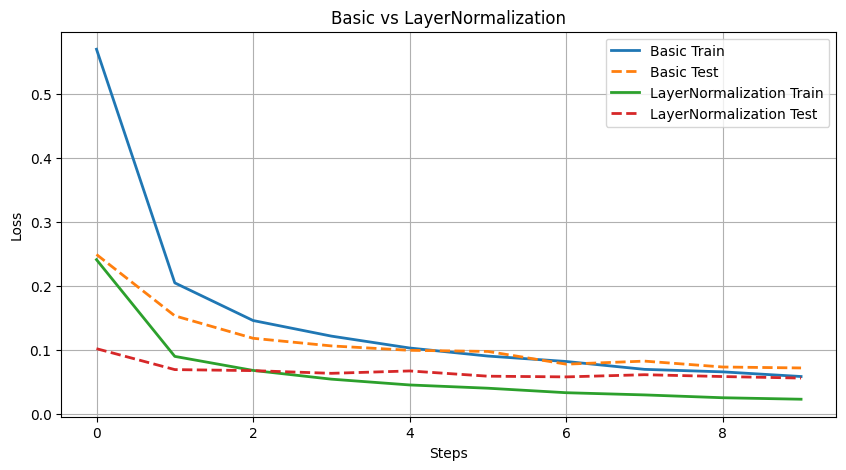

In [118]:
plt.figure(figsize=(10, 5))

plt.plot(trainB, label='Basic Train', linestyle='-', linewidth=2)
plt.plot(testB, label='Basic Test', linestyle='--', linewidth=2)
plt.plot(trainLN, label='LayerNormalization Train', linestyle='-', linewidth=2)
plt.plot(testLN, label='LayerNormalization Test', linestyle='--', linewidth=2)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Basic vs LayerNormalization')
plt.legend()
plt.grid(True)
plt.show()

LayerNormalization значительно ускорила скорость обучения модели 